In [1]:
# Core Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from portfolio_optimizer import portfolio_optimizer
from backtest import backtest, display_backtest_results
import warnings
warnings.filterwarnings("ignore")
from IPython.display import display
from typing import List

# data used to replicate paper results
# VTI, AGG, DBC, VIX
start_date = "2010-01-01"
end_date = "2020-01-01"
price_long = pd.read_csv("data_clean/long_format_daily_original_paper_data.csv")
price_long["Date"] = pd.to_datetime(price_long["Date"])
price_long = price_long.loc[(price_long["Date"] >= start_date) & (price_long["Date"] <= end_date), :]
price_wide = price_long.pivot(index='Date', columns='Ticker', values='Price')

portfolio_paper = portfolio_optimizer(price_long)

# Replicate Paper Result

In [2]:
%%time

# ORIGINAL LSTM
tf.keras.utils.set_random_seed(100)
weight_LSTM = portfolio_paper.optimize("LSTM")

1/1 [==============================] - 0s 302ms/step
successfully optimized portfolio weights
CPU times: total: 5.23 s
Wall time: 25.3 s


In [3]:
# static allocations
weight_alloc_1 = weight_LSTM.copy()
weight_alloc_2 = weight_LSTM.copy()
weight_alloc_3 = weight_LSTM.copy()
weight_alloc_4 = weight_LSTM.copy()
weight_alloc_1["Weight"] = 1/4
weight_alloc_2.loc[weight_alloc_2["Ticker"] == "VTI", "Weight"] = 1/2
weight_alloc_2.loc[weight_alloc_2["Ticker"] == "AGG", "Weight"] = 1/10
weight_alloc_2.loc[weight_alloc_2["Ticker"] == "DBC", "Weight"] = 1/5
weight_alloc_2.loc[weight_alloc_2["Ticker"] == "VIX", "Weight"] = 1/5
weight_alloc_3.loc[weight_alloc_3["Ticker"] == "VTI", "Weight"] = 1/10
weight_alloc_3.loc[weight_alloc_3["Ticker"] == "AGG", "Weight"] = 1/2
weight_alloc_3.loc[weight_alloc_3["Ticker"] == "DBC", "Weight"] = 1/5
weight_alloc_3.loc[weight_alloc_3["Ticker"] == "VIX", "Weight"] = 1/5
weight_alloc_4.loc[weight_alloc_4["Ticker"] == "VTI", "Weight"] = 2/5
weight_alloc_4.loc[weight_alloc_4["Ticker"] == "AGG", "Weight"] = 2/5
weight_alloc_4.loc[weight_alloc_4["Ticker"] == "DBC", "Weight"] = 1/10
weight_alloc_4.loc[weight_alloc_4["Ticker"] == "VIX", "Weight"] = 1/10

# benchmarks
weight_variance = portfolio_paper.optimize("variance")
weight_sharpe = portfolio_paper.optimize("sharpe")
weight_markowitz3 = portfolio_paper.optimize("markowitz3")
weight_DR = portfolio_paper.optimize("divers_ratio")
weight_MRC = portfolio_paper.optimize("marginal_risk_contribution")

successfully optimized portfolio weights
successfully optimized portfolio weights
successfully optimized portfolio weights
successfully optimized portfolio weights
successfully optimized portfolio weights


,Allocation 1,Allocation 2,Allocation 3,Allocation 4,maxSharpe,LSTM
avg annualized ret,0.215541,0.202867,0.171491,0.130455,0.113845,0.163654
avg annualized std,0.292685,0.204468,0.247665,0.093393,0.104974,0.300523
sharpe ratio,0.736427,0.992167,0.692432,1.396835,1.084509,0.544565
adjusted sharpe ratio,0.534864,0.067946,0.566041,-2.162932,-0.601160,0.554571
skewness,2.650719,3.042061,2.489633,3.208517,2.402081,1.011375
excess kurtosis,26.510230,34.975121,23.518777,40.535044,40.576034,5.941775
maximum drawdown,-0.104100,-0.072890,-0.096233,-0.039088,-0.092743,-0.233688
maximum drawdown length (days),412.000000,294.000000,412.000000,98.000000,79.000000,207.000000
VaR (95%),-0.022642,-0.015925,-0.019230,-0.007184,-0.008199,-0.025564
CVaR (95%),-0.030938,-0.021363,-0.026423,-0.009775,-0.014445,-0.039597


CPU times: total: 2.25 s
Wall time: 6.63 s


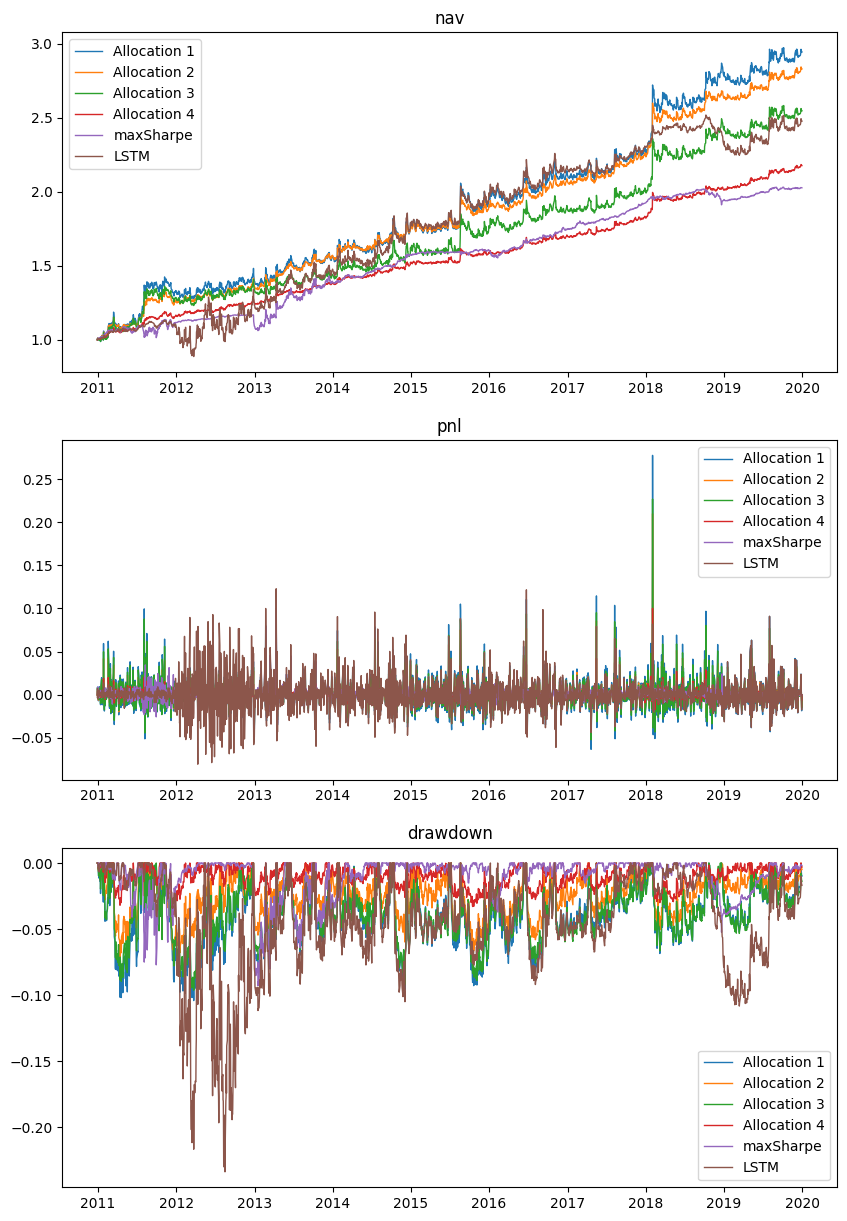

In [21]:
%%time
display_backtest_results(
    [weight_alloc_1, 
     weight_alloc_2, 
     weight_alloc_3, 
     weight_alloc_4,
     # weight_variance,
     weight_sharpe,
     # weight_markowitz3,
     # weight_DR,
     # weight_MRC,
     weight_LSTM, 
    ], 
    ["Allocation 1", "Allocation 2", "Allocation 3", "Allocation 4",
     # "minVar",
     "maxSharpe", 
     # "Markowitz 3.0", "maxDR", "minMRC",
     "LSTM"
    ]
)

# Model Improvement 1: loss function & L2 Reg

In [5]:
%%time

tf.keras.utils.set_random_seed(100)
# weight_LSTM_return = portfolio_paper.optimize("LSTM", loss = "return")
weight_LSTM_convex = portfolio_paper.optimize("LSTM", loss = "convex")
weight_LSTM_reg = portfolio_paper.optimize("LSTM", reg = True)
# weight_LSTM_sortino = portfolio_paper.optimize("LSTM", loss = "sortino")
# weight_LSTM_sortino_convex = portfolio_paper.optimize("LSTM", loss = "sortino_convex")

1/1 [==============================] - 0s 336ms/step
successfully optimized portfolio weights
1/1 [==============================] - 0s 314ms/step
successfully optimized portfolio weights
CPU times: total: 9 s
Wall time: 52.9 s


# Model Improvement 2: Structural Change - Autoencoder

In [6]:
%%time

tf.keras.utils.set_random_seed(110)
weight_LSTM_autoencoder = portfolio_paper.optimize("LSTM",
                                                   loss = "convex", 
                                                   structure_change = "autoencoder")

1/1 [==============================] - 0s 376ms/step
successfully optimized portfolio weights
CPU times: total: 875 ms
Wall time: 29.3 s


,LSTM_paper,LSTM_convex,LSTM_autoencoder_convex
avg annualized ret,0.163654,0.117332,0.079462
avg annualized std,0.300523,0.106394,0.070480
sharpe ratio,0.544565,1.102803,1.127450
adjusted sharpe ratio,0.554571,0.338847,0.978549
skewness,1.011375,1.893409,0.656469
excess kurtosis,5.941775,20.538169,4.822586
maximum drawdown,-0.233688,-0.061934,-0.085775
maximum drawdown length (days),207.000000,119.000000,618.000000
VaR (95%),-0.025564,-0.009281,-0.006835
CVaR (95%),-0.039597,-0.013088,-0.009385


CPU times: total: 281 ms
Wall time: 4.69 s


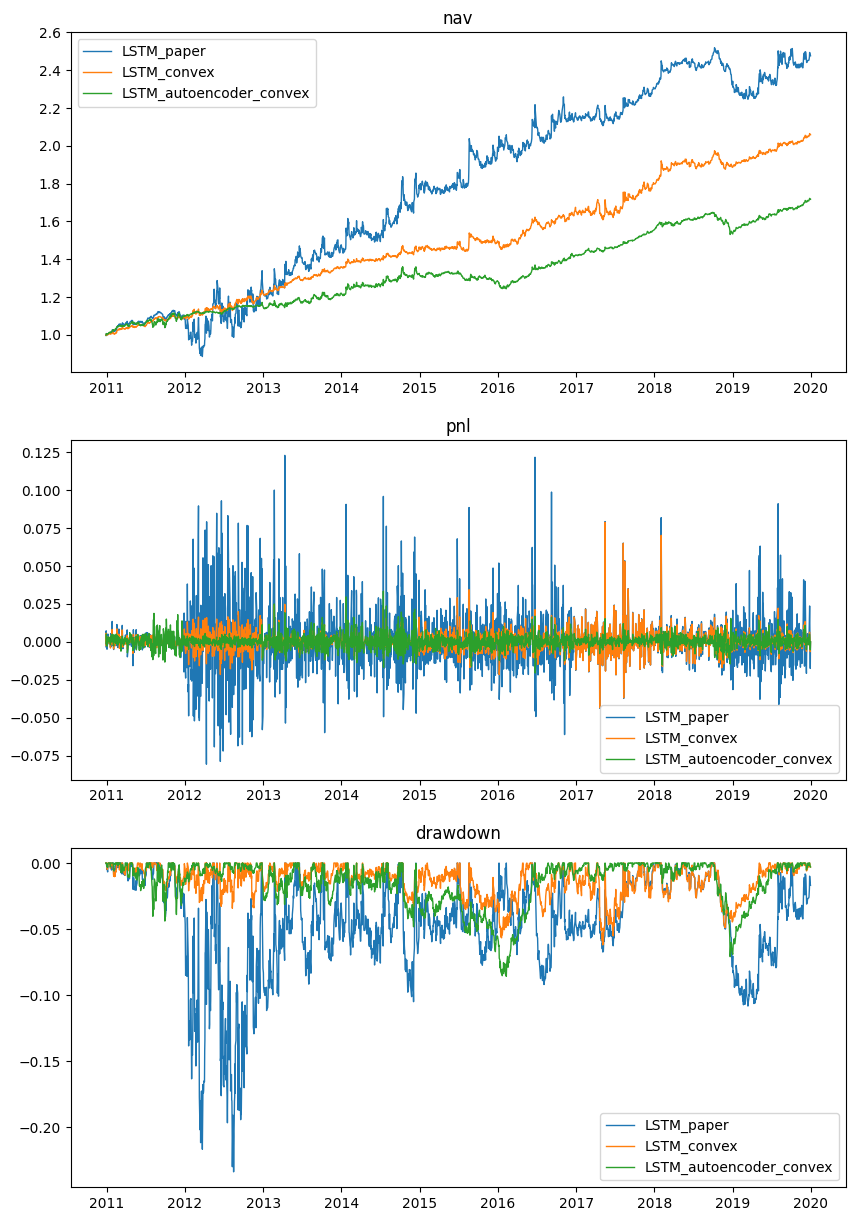

In [7]:
%%time
display_backtest_results(
    [weight_LSTM,
     weight_LSTM_convex,
     weight_LSTM_autoencoder,
    ],
    ["LSTM_paper", "LSTM_convex", "LSTM_autoencoder_convex"]
)

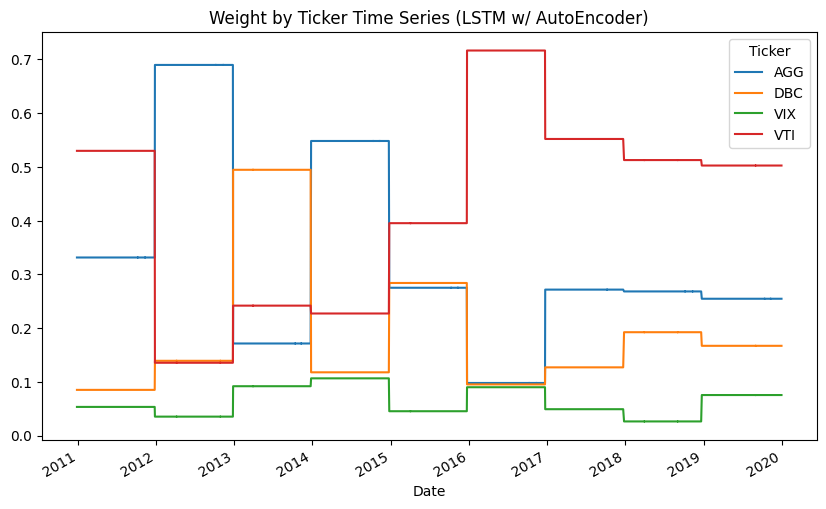

In [8]:
weight_LSTM_autoencoder.pivot(index='Date', columns='Ticker', values='Weight').plot(figsize=(10, 6))
plt.title('Weight by Ticker Time Series (LSTM w/ AutoEncoder)');

# Model Improvement 3: SAE_CNN_LSTM

In [9]:
%%time

tf.keras.utils.set_random_seed(100)
weight_CNN_SAE_LSTM = portfolio_paper.optimize("LSTM",
                                               loss = "convex", structure_change = "CNN_SAE_LSTM")

tf.keras.utils.set_random_seed(100)
weight_SAE_CNN_LSTM = portfolio_paper.optimize("LSTM",
                                               loss = "convex", structure_change = "SAE_CNN_LSTM")

tf.keras.utils.set_random_seed(100)
weight_SAE_3CNN_LSTM = portfolio_paper.optimize("LSTM",
                                                loss = "convex", structure_change = "SAE_3CNN_LSTM")

tf.keras.utils.set_random_seed(100)
weight_SAE_3CNN_LSTM_reg = portfolio_paper.optimize("LSTM",
                                                loss = "convex", structure_change = "SAE_3CNN_LSTM",
                                                reg = True)

1/1 [==============================] - 0s 476ms/step
successfully optimized portfolio weights
1/1 [==============================] - 0s 450ms/step
successfully optimized portfolio weights
1/1 [==============================] - 1s 543ms/step
successfully optimized portfolio weights
1/1 [==============================] - 1s 503ms/step
successfully optimized portfolio weights
CPU times: total: 21.1 s
Wall time: 2min 52s


,LSTM_paper,CNN_SAE_LSTM,SAE_CNN_LSTM,SAE_3CNN_LSTM,SAE_3CNN_LSTM_reg
avg annualized ret,0.163654,0.065410,0.086468,0.068074,0.072263
avg annualized std,0.300523,0.096829,0.076183,0.042589,0.049213
sharpe ratio,0.544565,0.675525,1.134997,1.598409,1.468361
adjusted sharpe ratio,0.554571,0.572724,-0.251687,0.843870,0.854771
skewness,1.011375,1.682012,2.237887,-0.174543,0.491817
excess kurtosis,5.941775,17.963321,30.648528,3.997548,5.991252
maximum drawdown,-0.233688,-0.143079,-0.077807,-0.065759,-0.046548
maximum drawdown length (days),207.000000,804.000000,717.000000,420.000000,261.000000
VaR (95%),-0.025564,-0.008193,-0.006348,-0.003802,-0.004571
CVaR (95%),-0.039597,-0.012426,-0.009635,-0.006153,-0.006680


CPU times: total: 1.73 s
Wall time: 12.6 s


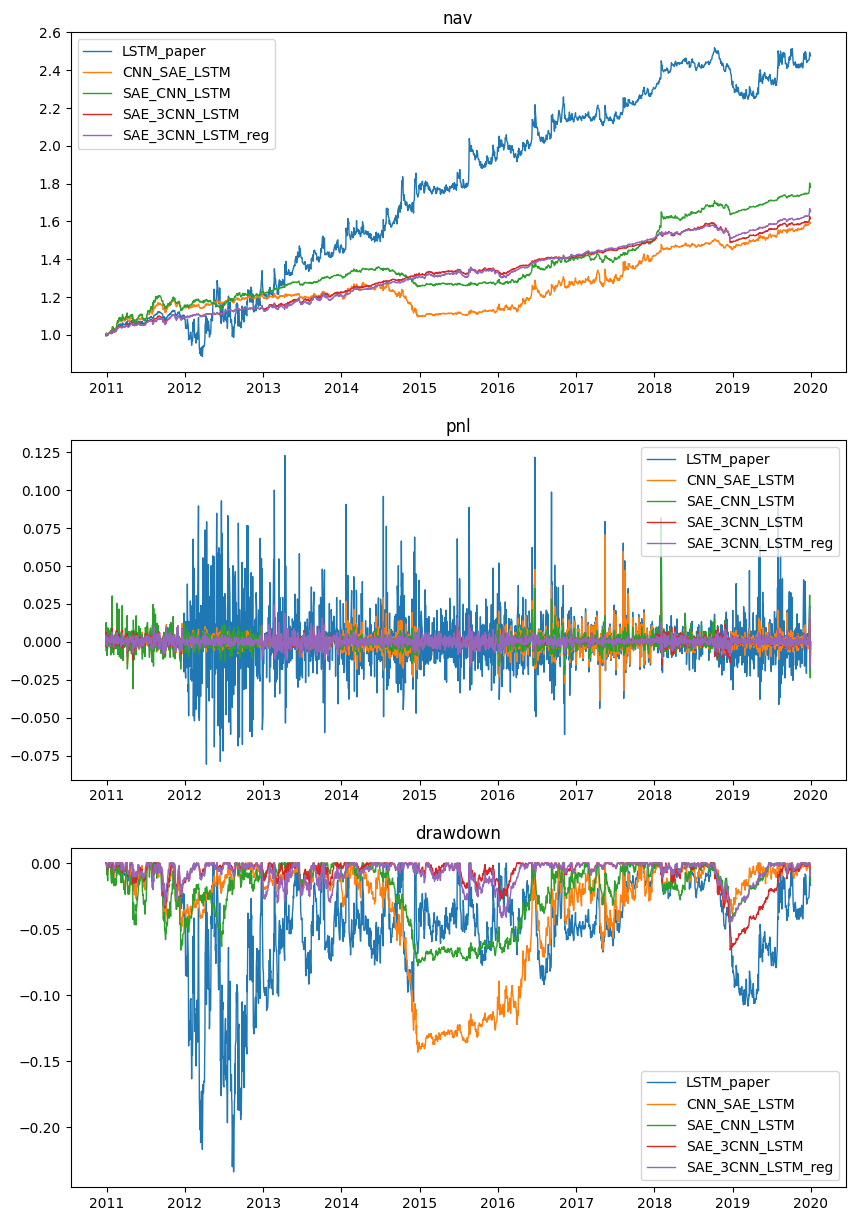

In [10]:
%%time
display_backtest_results(
    [weight_LSTM,
     weight_CNN_SAE_LSTM, 
     weight_SAE_CNN_LSTM,
     weight_SAE_3CNN_LSTM,
     weight_SAE_3CNN_LSTM_reg,
    ],
    ["LSTM_paper", "CNN_SAE_LSTM", "SAE_CNN_LSTM", "SAE_3CNN_LSTM", "SAE_3CNN_LSTM_reg"]
)

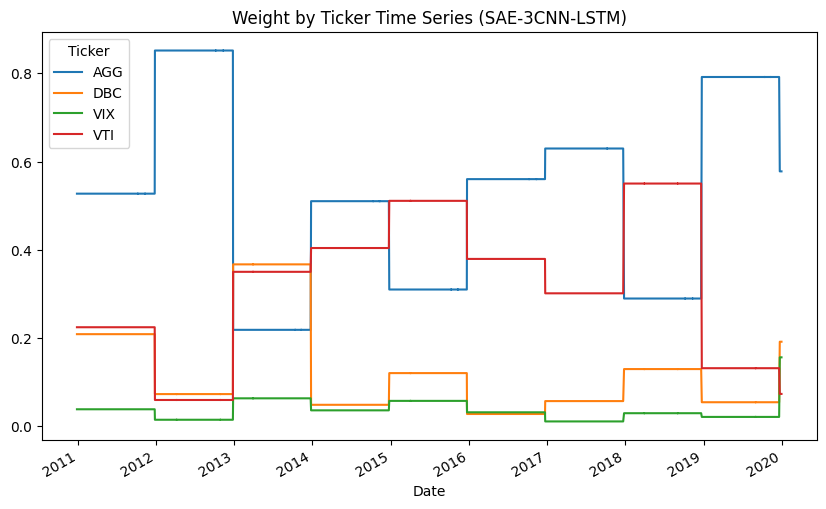

In [11]:
weight_SAE_3CNN_LSTM.pivot(index='Date', columns='Ticker', values='Weight').plot(figsize=(10, 6))
plt.title('Weight by Ticker Time Series (SAE-3CNN-LSTM)');

# Model Improvement 4: Double LSTM

In [12]:
%%time

tf.keras.utils.set_random_seed(100)
weight_DOUBLE_LSTM = portfolio_paper.optimize("LSTM", 
                                              loss = "convex", 
                                              structure_change = "DOUBLE_LSTM")  
weight_DOUBLE_LSTM_reg = portfolio_paper.optimize("LSTM", 
                                                  loss = "convex", 
                                                  structure_change = "DOUBLE_LSTM", 
                                                  reg= True)

1/1 [==============================] - 0s 347ms/step
successfully optimized portfolio weights
1/1 [==============================] - 1s 670ms/step
successfully optimized portfolio weights
CPU times: total: 9.94 s
Wall time: 1min 8s


,LSTM_paper,DOUBLE_LSTM,DOUBLE_LSTM_reg
avg annualized ret,0.163654,0.117332,0.168985
avg annualized std,0.300523,0.106394,0.209834
sharpe ratio,0.544565,1.102803,0.805324
adjusted sharpe ratio,0.554571,0.338847,-0.799931
skewness,1.011375,1.893409,5.522418
excess kurtosis,5.941775,20.538169,101.193420
maximum drawdown,-0.233688,-0.061934,-0.098502
maximum drawdown length (days),207.000000,119.000000,673.000000
VaR (95%),-0.025564,-0.009281,-0.015658
CVaR (95%),-0.039597,-0.013088,-0.022639


CPU times: total: 1.12 s
Wall time: 7.6 s


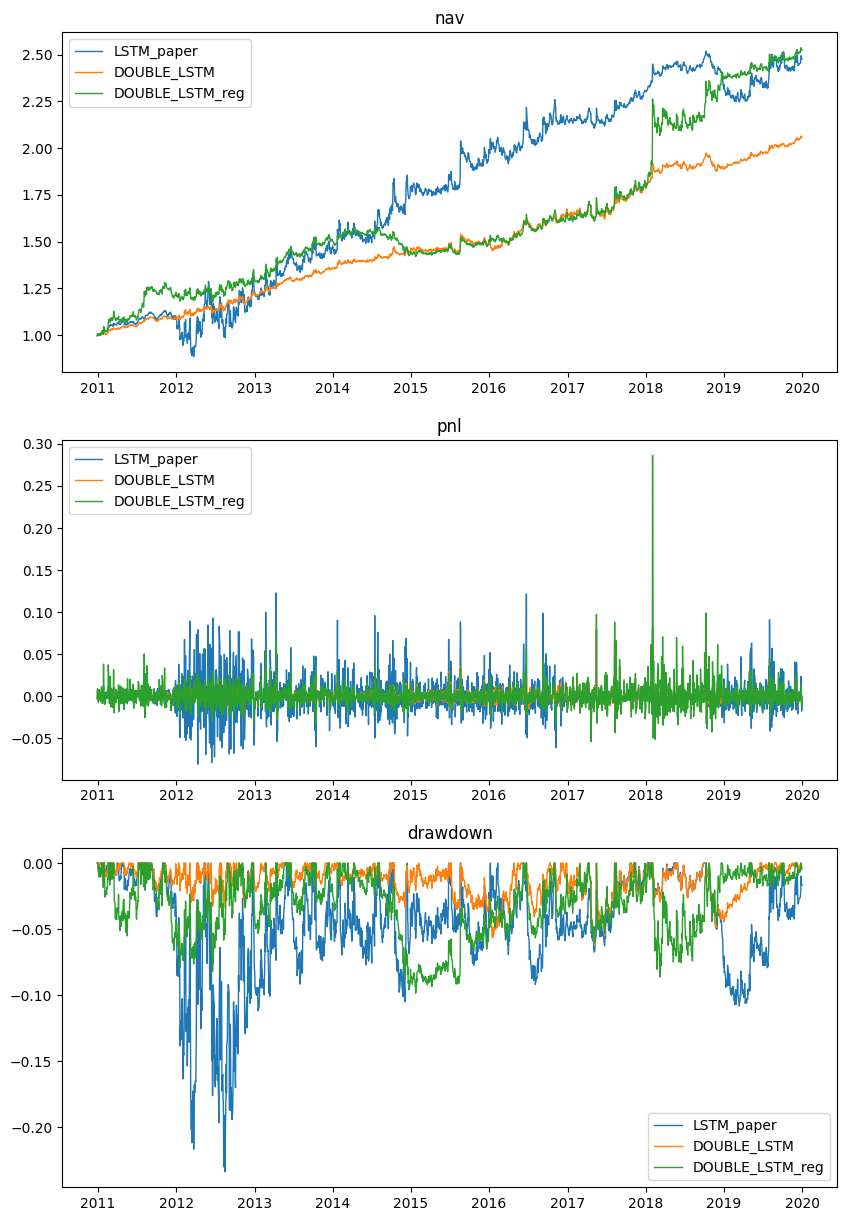

In [13]:
%%time
display_backtest_results(
    [weight_LSTM,
     weight_DOUBLE_LSTM,
     weight_DOUBLE_LSTM_reg
    ],
    ["LSTM_paper", "DOUBLE_LSTM", "DOUBLE_LSTM_reg"]
)

# Other Improvement: Increase Rebalance Frequency

In [ ]:
weight_sharpe_monthly = portfolio_paper.optimize("sharpe",)

In [14]:
%%time

tf.keras.utils.set_random_seed(100)
weight_LSTM_monthly = portfolio_paper.optimize("LSTM",
                                               rebalance_frequency = 21)

1/1 [==============================] - 0s 381ms/step
successfully optimized portfolio weights
CPU times: total: 50.6 s
Wall time: 6min 33s


In [15]:
%%time

tf.keras.utils.set_random_seed(100)
weight_LSTM_convex_monthly = portfolio_paper.optimize("LSTM",
                                                       loss = "convex", 
                                                       rebalance_frequency = 21
                                                      )

1/1 [==============================] - 0s 424ms/step
successfully optimized portfolio weights
CPU times: total: 10.4 s
Wall time: 5min 6s


In [16]:
%%time

tf.keras.utils.set_random_seed(100)
weight_SAE_CNN_LSTM_monthly = portfolio_paper.optimize("LSTM",
                                                       loss = "convex", 
                                                       structure_change = "SAE_CNN_LSTM",
                                                       rebalance_frequency = 21
                                                      )

1/1 [==============================] - 0s 494ms/step
successfully optimized portfolio weights
CPU times: total: 23.3 s
Wall time: 7min 51s


In [17]:
%%time

tf.keras.utils.set_random_seed(100)
weight_SAE_3CNN_LSTM_monthly = portfolio_paper.optimize("LSTM",
                                                       loss = "convex", 
                                                       structure_change = "SAE_3CNN_LSTM",
                                                       rebalance_frequency = 21
                                                      )

1/1 [==============================] - 1s 583ms/step
successfully optimized portfolio weights
CPU times: total: 32.7 s
Wall time: 8min 15s


In [18]:
%%time

tf.keras.utils.set_random_seed(100)
weight_double_LSTM_monthly = portfolio_paper.optimize("LSTM",
                                                       loss = "convex", 
                                                       structure_change = "DOUBLE_LSTM",
                                                       rebalance_frequency = 21
                                                      )

1/1 [==============================] - 0s 407ms/step
successfully optimized portfolio weights
CPU times: total: 30.3 s
Wall time: 6min 50s


,paper_LSTM_annual,paper_LSTM_monthly,LSTM_convex_monthly,SAE_CNN_LSTM_monthly,SAE_3CNN_LSTM_monthly,double_LSTM_monthly
avg annualized ret,0.163654,0.164493,0.126221,0.075981,0.065737,0.126221
avg annualized std,0.300523,0.395045,0.168584,0.072879,0.067635,0.168584
sharpe ratio,0.544565,0.416391,0.748711,1.042573,0.971929,0.748711
adjusted sharpe ratio,0.554571,0.406825,0.272188,0.764332,0.374100,0.272188
skewness,1.011375,2.124249,2.784829,0.603004,1.316488,2.784829
excess kurtosis,5.941775,23.586349,42.127075,8.206199,21.045365,42.127075
maximum drawdown,-0.233688,-0.251398,-0.104874,-0.065115,-0.091219,-0.104874
maximum drawdown length (days),207.000000,274.000000,300.000000,59.000000,452.000000,300.000000
VaR (95%),-0.025564,-0.032888,-0.012385,-0.007082,-0.005454,-0.012385
CVaR (95%),-0.039597,-0.053794,-0.021326,-0.010112,-0.009719,-0.021326


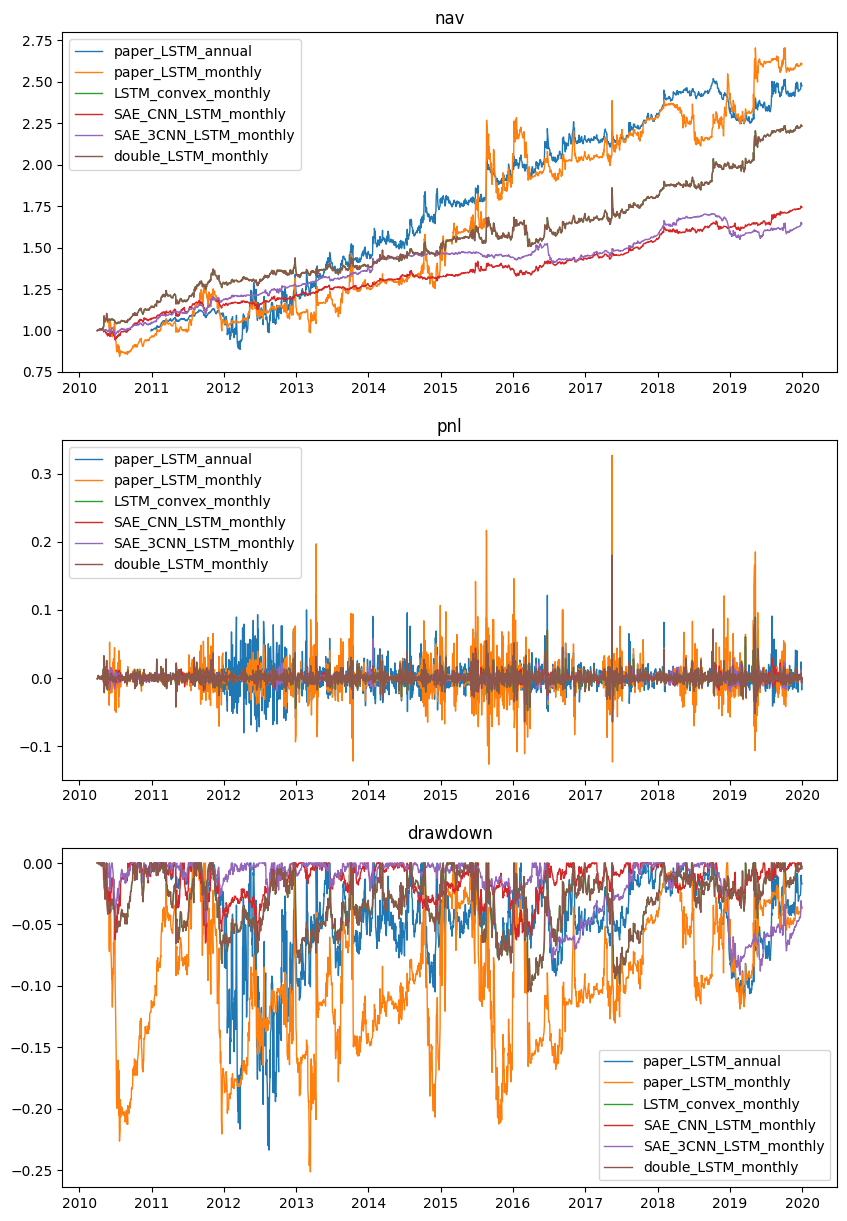

In [20]:
display_backtest_results(
    [weight_LSTM,
     weight_LSTM_monthly,
     weight_LSTM_convex_monthly,
     weight_SAE_CNN_LSTM_monthly,
     weight_SAE_3CNN_LSTM_monthly,
     weight_double_LSTM_monthly
    ],
    ["paper_LSTM_annual", 
     "paper_LSTM_monthly", 
     "LSTM_convex_monthly",
     "SAE_CNN_LSTM_monthly", 
     "SAE_3CNN_LSTM_monthly", 
     "double_LSTM_monthly"]
)